In [1]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, InputLayer
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random

2025-03-21 18:02:51.787262: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Chemins des dossiers contenant les fichiers CSV
base_path = './data/processed'
names = ['Antoine', 'Corentin', 'Felix', 'Leo', 'Vladislav', 'Matthieu', 'Serge']

# Liste pour stocker les données et les étiquettes
train_data = []
train_labels = []

test_data = []
test_labels = []

frame_size = 250

In [3]:
# Fonction pour créer des trames
def create_frames(data, frame_size=250, hop_length=250):
    frames = []
    for start in range(0, len(data) - frame_size + 1, hop_length):
        frame = data[start:start + frame_size]
        if len(frame) == frame_size:
            frames.append(frame)
    return np.array(frames)

In [4]:
all_test_files = []
# Charger les données
for name in names:
    folder_path = os.path.join(base_path, name)
    all_files = glob.glob(folder_path + '/*.csv')
    test_files = random.sample(all_files, 2)
    all_test_files.extend(test_files)
    for file_path in all_files:
        file_path_no_prefix = os.path.basename(file_path)
        df = pd.read_csv(file_path)
        acc_data = df['acceleration (g)'].values

        # Créer des trames à partir des données d'accélération
        frames = create_frames(acc_data, frame_size=frame_size, hop_length=1)

        # Ajouter les trames et les étiquettes aux listes
        # Train test split
        if file_path in test_files:
            for frame in frames:
                test_data.append(frame)
                test_labels.append(name)
        else:
            for frame in frames:
                train_data.append(frame)
                train_labels.append(name)
                
print(all_test_files)

['./data/processed/Antoine/accelerometer2_data.csv', './data/processed/Antoine/accelerometer7_data.csv', './data/processed/Corentin/accelerometer1_data.csv', './data/processed/Corentin/accelerometer2_data.csv', './data/processed/Felix/accelerometer9_data.csv', './data/processed/Felix/accelerometer7_data.csv', './data/processed/Leo/accelerometer1_data.csv', './data/processed/Leo/accelerometer6_data.csv', './data/processed/Vladislav/accelerometer3_data.csv', './data/processed/Vladislav/accelerometer7_data.csv', './data/processed/Matthieu/accelerometer1_data.csv', './data/processed/Matthieu/accelerometer2_data.csv', './data/processed/Serge/accelerometer9_data.csv', './data/processed/Serge/accelerometer7_data.csv']


In [5]:
# Convertir en tableaux numpy
train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Encoder les étiquettes
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

train_labels_encoded = to_categorical(train_labels_encoded)
test_labels_encoded = to_categorical(test_labels_encoded)

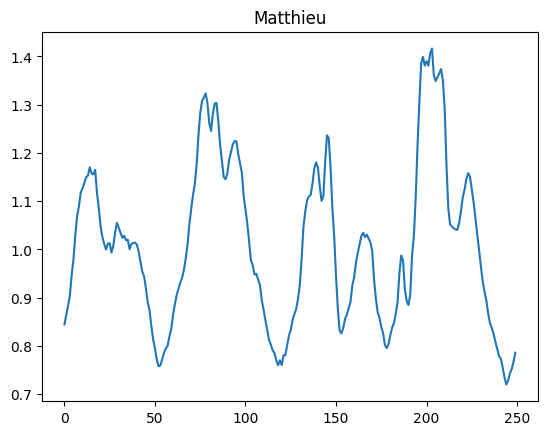

In [6]:
def plot_random_frame(data, labels):
    idx = np.random.randint(0, len(data), 1)
    plt.plot(data[idx].flatten())
    plt.title(labels[idx][0])
    plt.show()

plot_random_frame(train_data, train_labels)

In [7]:
print(train_data.shape, train_labels_encoded.shape)
print(test_data.shape, test_labels_encoded.shape)

(36638, 250) (36638, 7)
(9613, 250) (9613, 7)


In [8]:
X_train, X_test, y_train, y_test = train_data.reshape(train_data.shape[0], train_data.shape[1], 1), test_data.reshape(test_data.shape[0], test_data.shape[1], 1), train_labels_encoded, test_labels_encoded


In [11]:
# Construire le modèle
model = Sequential([
    InputLayer(input_shape=(frame_size, 1)),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(pool_size=2, strides=2),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(pool_size=4, strides=4),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(pool_size=4, strides=4),
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(pool_size=4, strides=4),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(names), activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
print(model.input_shape)

/usr/local/Caskroom/miniconda/base/envs/arduino-streamlit/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 248, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 124, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 122, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 28, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 5, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,575 (678.03 KB)

 Trainable params: 173,575 (678.03 KB)

 Non-trainable params: 0 (0.00 B)

(None, 250, 1)


In [12]:

# Entraîner le modèle
history=model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))


Epoch 1/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 30s 97ms/step - accuracy: 0.1972 - loss: 1.8643 - val_accuracy: 0.5872 - val_loss: 1.0945
Epoch 2/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 29s 101ms/step - accuracy: 0.6240 - loss: 0.9518 - val_accuracy: 0.7878 - val_loss: 0.7596
Epoch 3/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 29s 102ms/step - accuracy: 0.8521 - loss: 0.4510 - val_accuracy: 0.8235 - val_loss: 0.6238
Epoch 4/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - accuracy: 0.9050 - loss: 0.2835 - val_accuracy: 0.8008 - val_loss: 0.8957
Epoch 5/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.9315 - loss: 0.2052 - val_accuracy: 0.8371 - val_loss: 0.7045
Epoch 6/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - accuracy: 0.9558 - loss: 0.1359 - val_accuracy: 0.8243 - val_loss: 0.7390
Epoch 7/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - accuracy: 0.9596 - loss: 0.1218 - val_accuracy: 0.8393 - val_loss: 0.9073
Epoch 8/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - accuracy: 0.9717 - loss: 0.08

In [13]:

# Évaluer le modèle
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8096 - loss: 1.3737
Accuracy: 83.06%


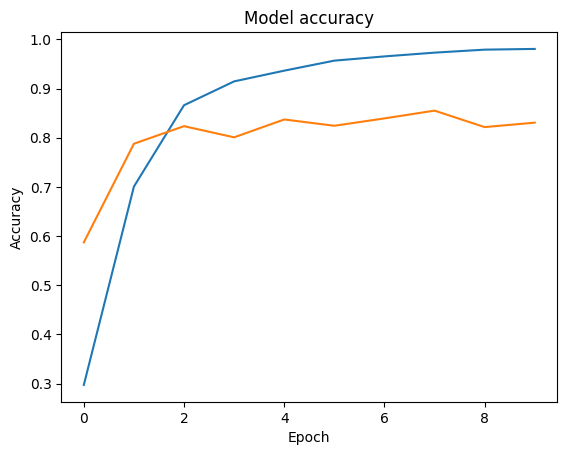

In [14]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()
    
plot_history(history)

In [ ]:
#model.save(f"models/CNN_4layers_{frame_size}_{accuracy*100:.2f}.keras")

301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


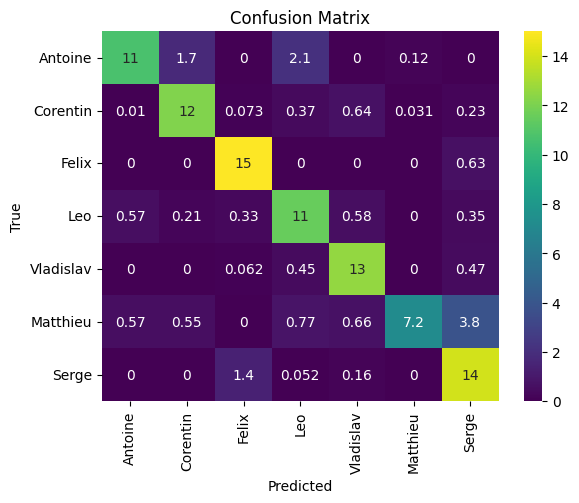

In [16]:
y_pred = model.predict(X_test)

conf = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))/len(y_test) * 100
sns.heatmap(conf, annot=True, xticklabels=names, yticklabels=names, cmap="viridis")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [17]:
def predict(df):
    frames = create_frames(df['acceleration (g)'].values, frame_size=frame_size, hop_length=1)
    frames = frames.reshape(frames.shape[0], frames.shape[1], 1)
    print(frames.shape)
    predictions = model.predict(frames)
    predictions_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
    #predictions_labels = [names[label] for label in predictions_labels]
    return predictions_labels


test_recording_path = "./data/misc/accelerometer11_data.csv"
df = pd.read_csv(test_recording_path)

predictions = predict(df)

print(predictions)


(1754, 250, 1)
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
['Vladislav' 'Vladislav' 'Vladislav' ... 'Vladislav' 'Vladislav'
 'Vladislav']


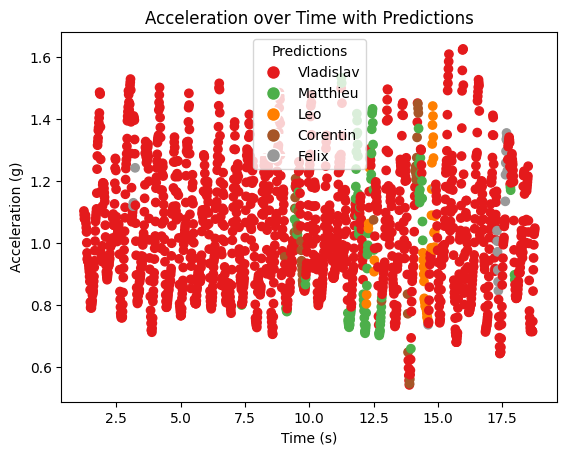

Counter({'Vladislav': 1547,
         'Matthieu': 103,
         'Leo': 43,
         'Corentin': 39,
         'Felix': 22})

In [18]:

def show_predictions(df, predictions):
    n = len(predictions)
    m = len(df)
    # Create a colormap
    c = Counter(predictions)
    mc = c.most_common()
    sorted_list = [x[0] for x in mc]
    unique_predictions = sorted_list
    colors = plt.get_cmap('Set1', len(unique_predictions))
    color_map = {label: colors(i) for i, label in enumerate(unique_predictions)}
    
    # Plot the data with colors based on predictions
    fig, ax = plt.subplots()
    ax.scatter(df['time (s)'][(m-n)//2:n+(m-n)//2], df['acceleration (g)'][(m-n)//2:n+(m-n)//2], c=[color_map[label] for label in predictions])
    
    
    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[label], markersize=10) for label in sorted_list]
    plt.legend(handles, sorted_list, title="Predictions")
    
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (g)')
    plt.title('Acceleration over Time with Predictions')
    plt.show()
    
    return c

show_predictions(df, predictions)